# Evaluation: p2p
## Prerequisite
- Please install python libraries mentioned in requirements.txt, you can do it using pip install -r requirements.txt
    - The code is tested using the versions that are specified in requirements.txt
- Please download and unzip "SAP ERP IDES instance - P2P log" in JSON-OCEL format from http://ocel-standard.org and extrract it under datasets folder

In [1]:
import pm4py
from pm4py.visualization.ocel.ocdfg import visualizer as ocdfg_visualization
import processmining.discovery.ocdfg.markov as ocdfgmrkv
import processmining.log.ocel as ocelhelper

from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery
from pm4py.algo.conformance.footprints import algorithm as footprints_conformance

Let's start by discovering an ocdfg from the log file. 

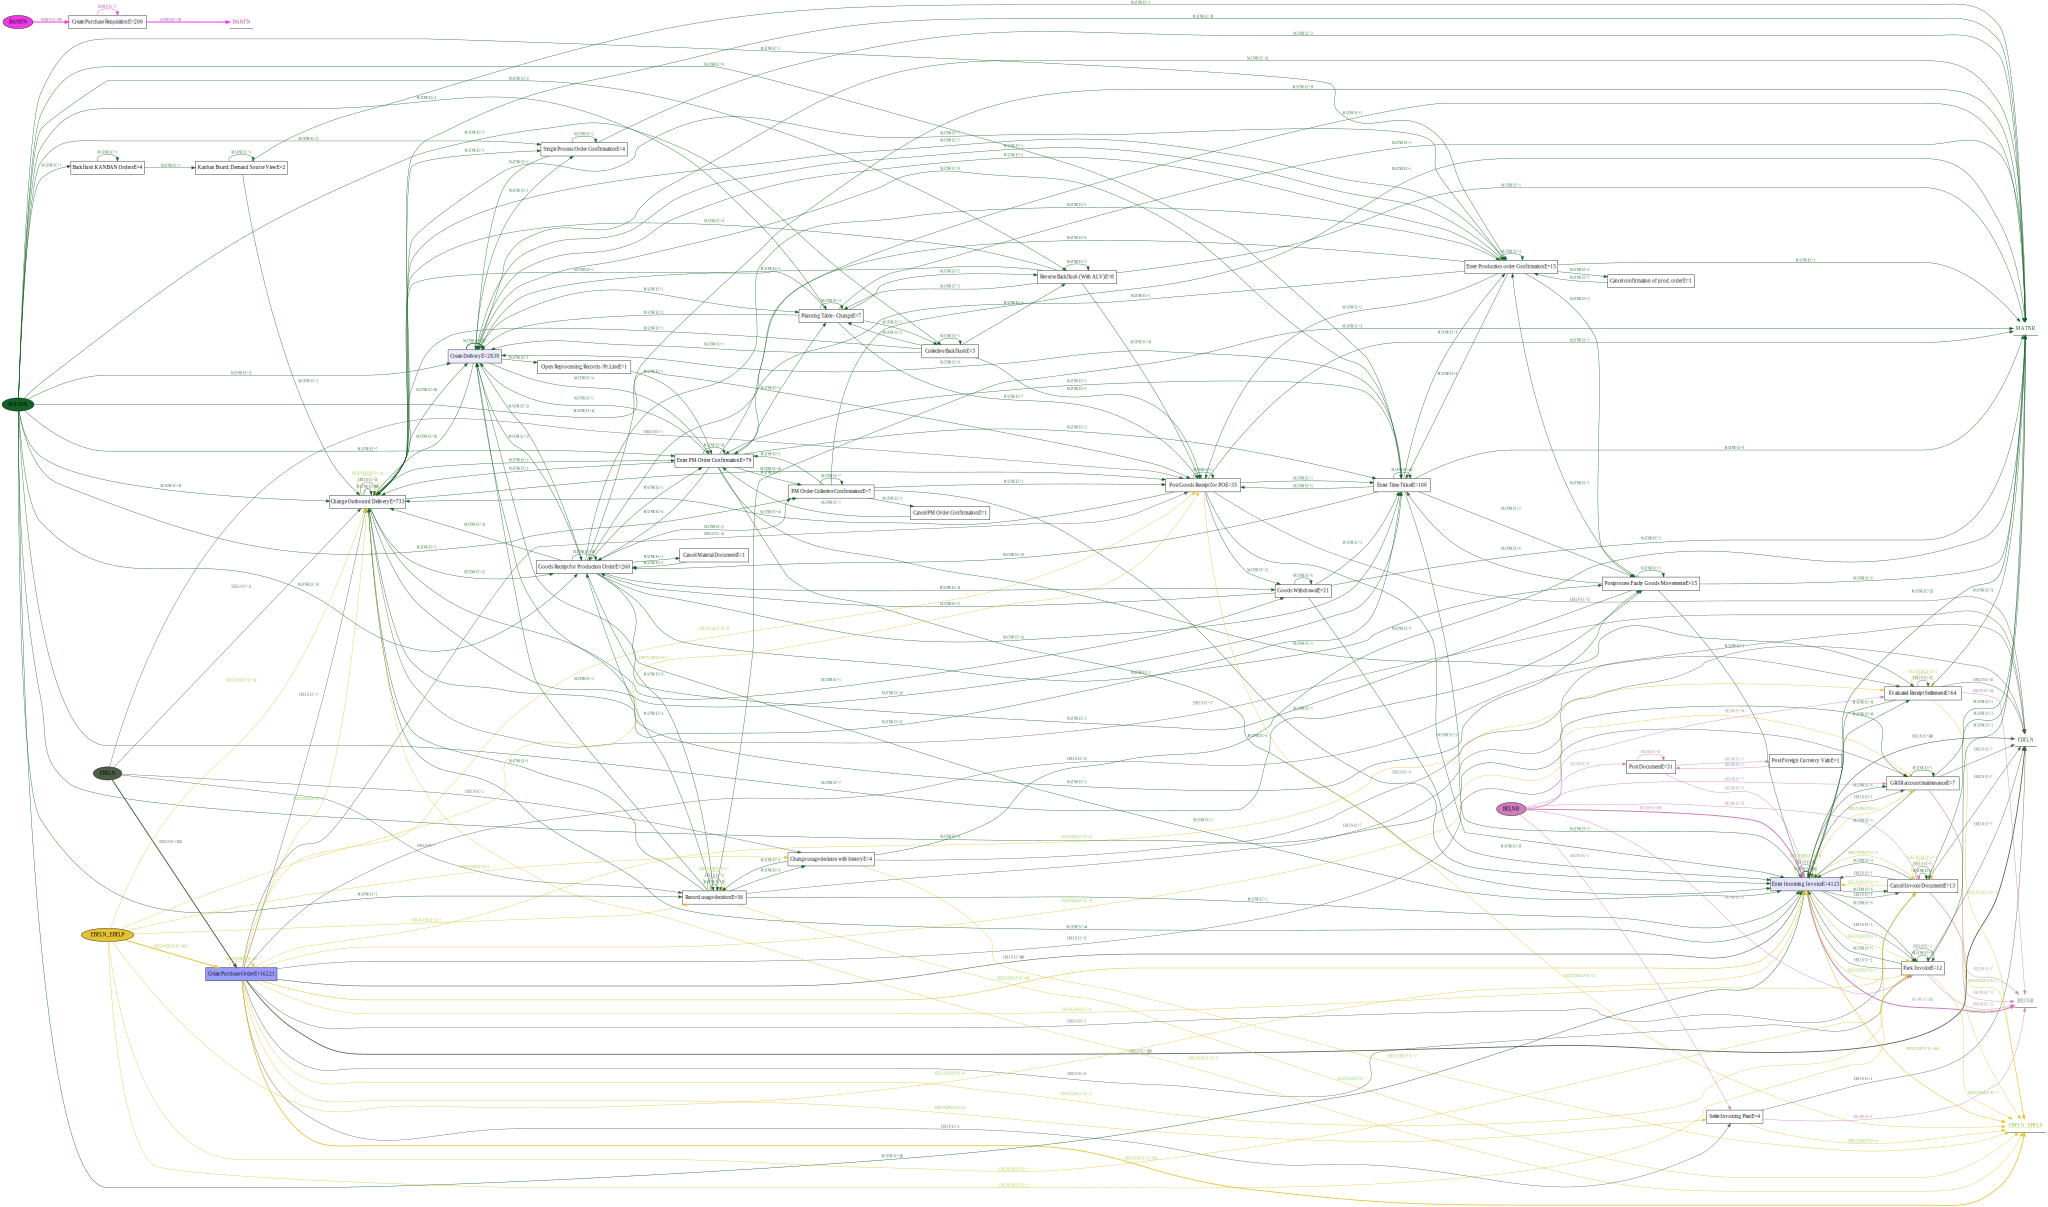

In [2]:
file_path = './datasets/p2p.jsonocel'
ocel = pm4py.read_ocel(file_path)
ocdfg = pm4py.discover_ocdfg(ocel)
ocdfg_visualization.apply(ocdfg)

Here, we calculate markov ocdfg, discover sets of possible clusters by tuning the threshold parameter:

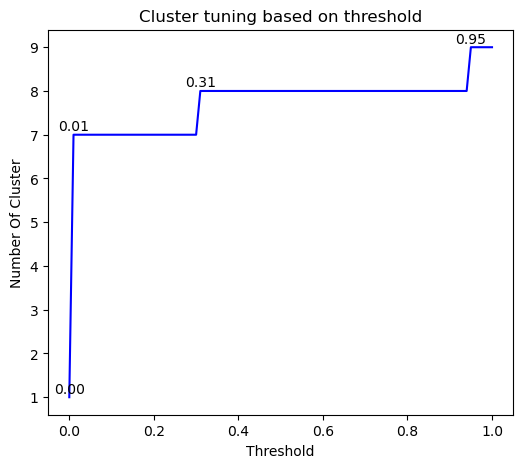

In [3]:
ocdfg_markov = ocdfgmrkv.discover_ocdfg_markov(ocdfg)
sim_matrix = ocdfgmrkv.discover_similarity_matrix(ocdfg_markov)
tunned_similarity_clusters = ocdfgmrkv.similarity_tuning(sim_matrix)
st = ocdfgmrkv.get_similarity_tuning_plot(tunned_similarity_clusters)

In tuning, we can have multiple sets of similar clusters for different thresholds. For example, The clusters for the threshold between 0.01 and 0.30 are the same. This is needed to visualize the start and end of the line. In order to calculate the unique number of clusters with unique members, we optimize it based on a threshold that has a minimum value. The result is shown below. 

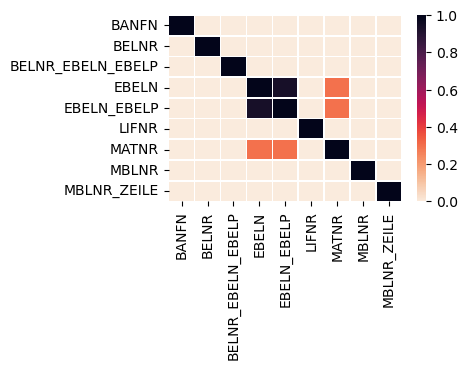

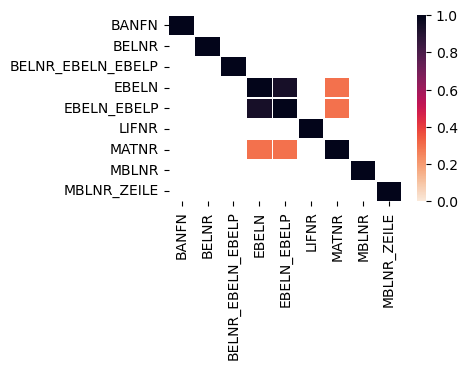

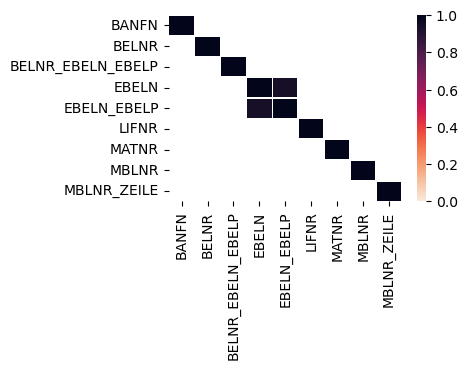

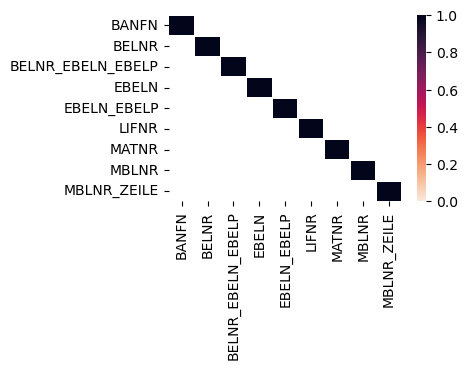

In [4]:
res = ocdfgmrkv.get_optimised_similarity_tuning(sim_matrix)
for thresh, v in res.items():
    test_matrix = ocdfgmrkv.filter_matrix(sim_matrix, thresh)
    s = ocdfgmrkv.get_similarity_plot(test_matrix, size=(5,4), annotation=False)

Let's see the result of cluster discovery when we set the threshold to 31 %: 

In [5]:
clusters_dic = ocdfgmrkv.discover_clusters(sim_matrix, 0.31)
clusters_dic

{0: {'BELNR_EBELN_EBELP'},
 1: {'MATNR'},
 2: {'BANFN'},
 3: {'EBELN', 'EBELN_EBELP'},
 4: {'MBLNR_ZEILE'},
 5: {'MBLNR'},
 6: {'LIFNR'},
 7: {'BELNR'}}

As can be seen, EBELN and EBELN_EBELP share similar behavioud in compare to rest of remaining clusters. Lets visualize their ocdfg:

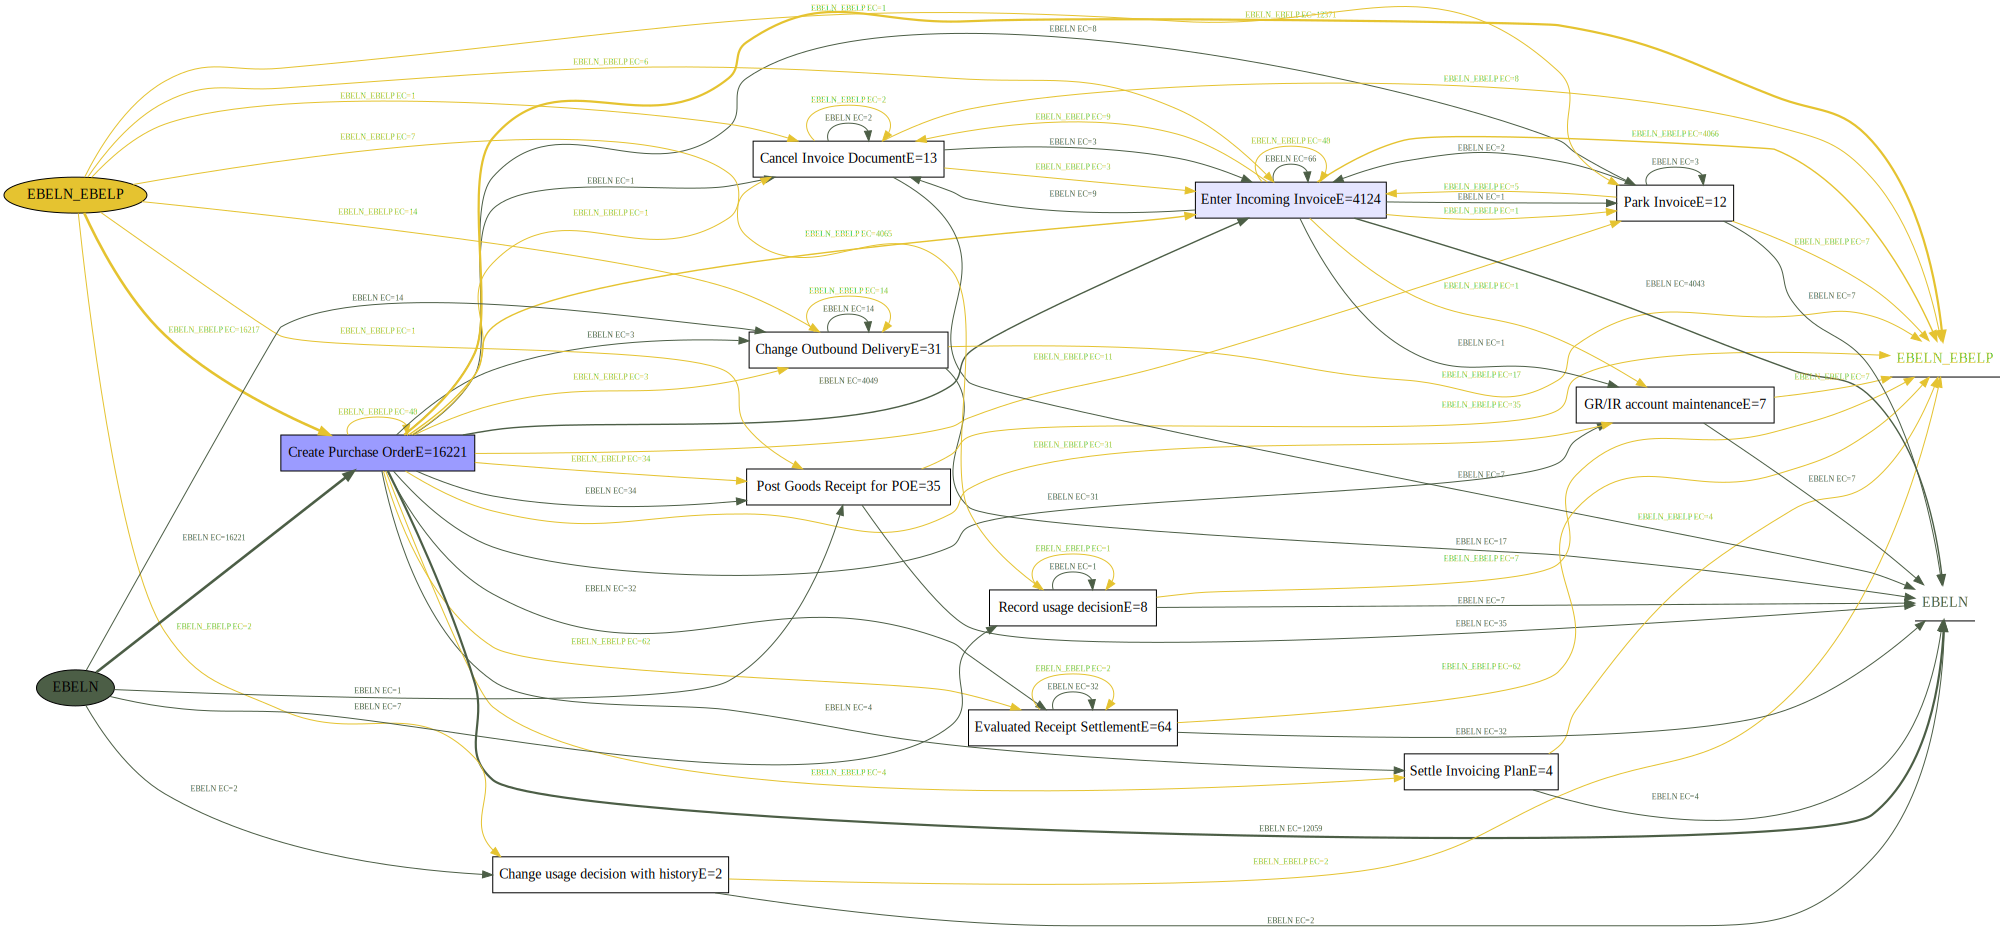

In [6]:
filtered_ocel = ocelhelper.filter_ocel(ocel, event_threshold=0, object_types={'EBELN', 'EBELN_EBELP'})
filtered_ocdfg = pm4py.discover_ocdfg(filtered_ocel)
ocdfg_visualization.apply(filtered_ocdfg)

## Evaluation

To evaluate if our approach could discover correct clusters based on the similarity of the behavior of different object types, we flatten the log based on different object types and calculate the footprint of their process model that is discovered using inductive miner. Then, we calculate the similarity using footprint conformance checking. The results are aligned with our findings. 

In [7]:
def get_footprint(ocel, ot):
    flog_order = pm4py.ocel_flattening(ocel, ot)
    net, im, fm = inductive_miner.apply(flog_order)
    fp_net = footprints_discovery.apply(net, im, fm)
    return fp_net

In [8]:
pairs = []
for ot1 in ocdfg['object_types']:
    for ot2 in ocdfg['object_types']:
        pairs.append((ot1,ot2))
        
ccres = {}
for p in pairs:
    fp_1 = get_footprint(ocel, p[0])
    fp_2 = get_footprint(ocel, p[1])
    ccres[p] = footprints_conformance.apply(fp_1, fp_2)
    
matrix = {}
for k, v in ccres.items():
    matrix[k] = len(v)

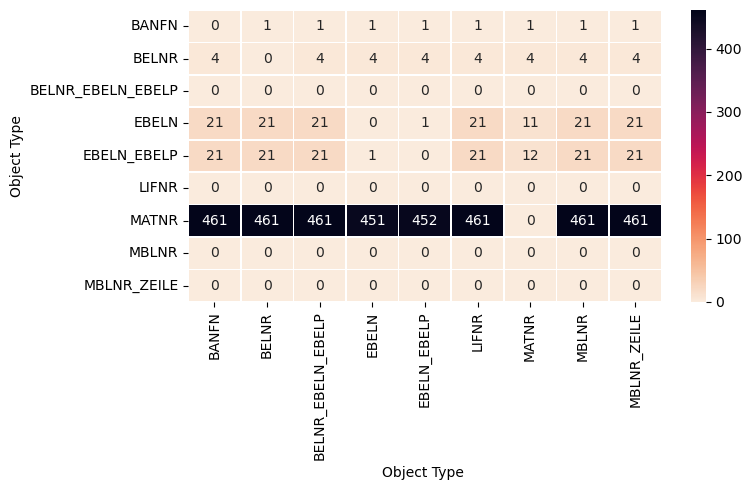

In [9]:
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd 
import seaborn as sns

style.use('default')
df_matrix = pd.Series(matrix).reset_index()
df_matrix.columns = ['Object Type', 'Object Type ', 'Similarity']        
fig, axs = plt.subplots(ncols=1, gridspec_kw=dict(width_ratios=[1]), figsize=(8,5))
df_in = df_matrix.pivot_table(index='Object Type',columns='Object Type ', values='Similarity', aggfunc='sum')
cmap = sns.cm.rocket_r
svm = sns.heatmap(df_in, annot=True, fmt="d", linewidths=.5 , ax=axs, vmin = 0.0, cmap = cmap)
svm.figure.tight_layout()